In [24]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import math
import time
import matplotlib.pyplot as plt

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import requests
import pandas_ta as ta
from datetime import datetime
from binance.client import Client
client = Client(tld='us')

In [25]:
startDate = '2022-01-01 00:00:00'
testDate  = '2024-06-01 00:00:00'
r = client.get_historical_klines('BTCUSDT','1h',startDate)

In [26]:
df = pd.DataFrame(r)

In [27]:
columns_to_convert = ['quoteAssetVolume', 'TakerBaseVolume', 'TakerQuoteVolume', 'Ignore']

colnames = ['openTime','openPrice','highPrice','lowPrice','closePrice','volume','closeTime','quoteAssetVolume','NumberOfTrades','TakerBaseVolume','TakerQuoteVolume','Ignore']
df.columns = colnames
df['closeTime'] = pd.to_datetime(df['closeTime'], unit='ms')
df = df.astype({'closePrice':'float','openPrice':'float','highPrice':'float','lowPrice':'float','volume':'float'})
df['return'] = df['closePrice'].pct_change()
df['return_next'] = df['return'].shift(-1).fillna(0)

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Additional features
df['f_high'] = df['highPrice'].pct_change().fillna(0)
df['f_low'] = df['lowPrice'].pct_change().fillna(0)
df['f_high_low'] = (df['highPrice'] - df['lowPrice']) / (df['highPrice'] + df['lowPrice']).fillna(0)
df['f_open_close'] = (df['openPrice'] - df['closePrice']) / (df['openPrice'] + df['closePrice']).fillna(0)
df['f_ntv'] = df['NumberOfTrades'].pct_change().where(df['NumberOfTrades'].pct_change() != np.inf, np.nan).ffill().fillna(0)
df['f_taker_volume_ratio'] = (df['TakerBaseVolume'] / df['volume']).fillna(0)
df['f_rolling_std'] = df['closePrice'].rolling(window=20).std().fillna(0)
# Lagged returns
for lag in [1, 2, 3, 5, 10]:
    df[f'lag_return_{lag}'] = df['return'].shift(lag)
# Feature engineering for targets
df['return_next_class'] = np.where(df['return_next'] > 0, 1, 0)

df['predict'] = 1
df.set_index("closeTime", inplace= True)
df.head(2)

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,...,f_ntv,f_taker_volume_ratio,f_rolling_std,lag_return_1,lag_return_2,lag_return_3,lag_return_5,lag_return_10,return_next_class,predict
closeTime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:59:59.999,1640995200000,46192.43,46715.27,46192.43,46670.23,17.363974,806563.321292,543,12.215618,567219.242025,...,0.000000,0.703504,0.0,NaN,NaN,NaN,NaN,NaN,1,1
2022-01-01 01:59:59.999,1640998800000,46643.41,46932.99,46564.34,46780.47,6.799312,317924.865149,336,2.050074,96019.169706,...,-0.381215,0.301512,0.0,NaN,NaN,NaN,NaN,NaN,0,1


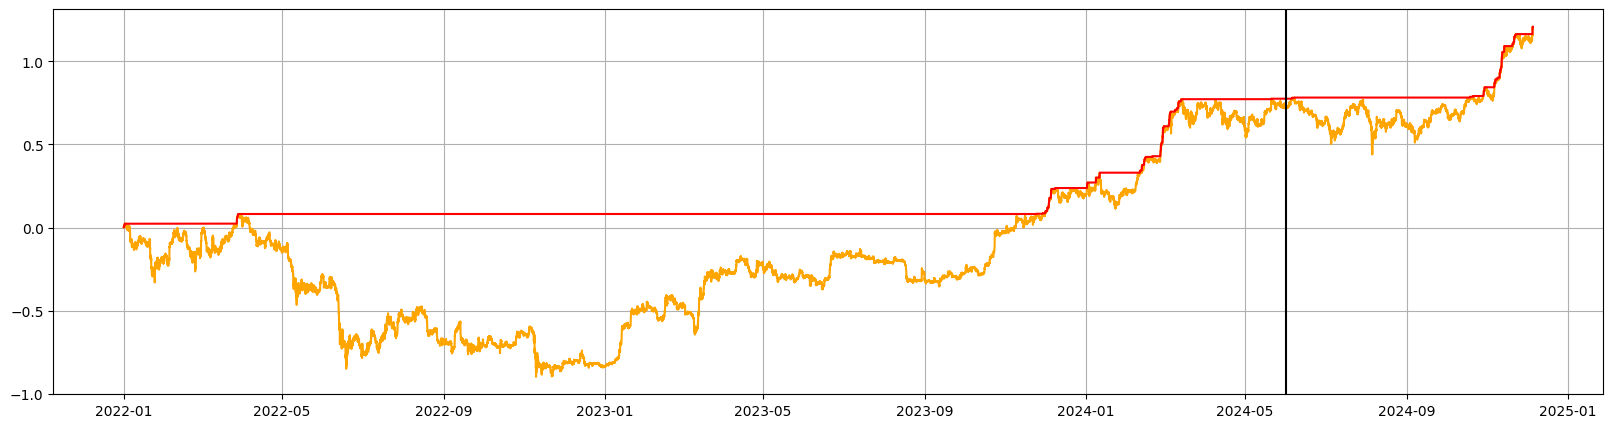

In [28]:
def func_plot(df):
  df['pnl'] = df['return_next'] * df['predict']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  plt.figure(figsize=(20,5))
  plt.plot(df['pnl_cumsum'],color='orange')
  plt.plot(df['pnl_cumsum_max'],color='red')
  plt.axvline(x = pd.to_datetime(testDate), color='black')
  plt.grid()
  plt.show()

func_plot(df)

In [29]:
def func_model_performance(df):
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()

  pnl_train = round(train['pnl'].sum(),6)
  pnl_test = round(test['pnl'].sum(),6)

  mdd_train = round(train['pnl_dd'].max(),6)
  mdd_test = round(test['pnl_dd'].max(),6)

  sharpe_train = round(pnl_train/mdd_train,6)
 # sharpe_train = train['pnl'].mean()/train['pnl'].std()*(252*24)**0.5

  sharpe_test = round(pnl_test/mdd_test,6)

  print('            train     test')
  print('PNL      : {0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
  print('MDD      : {0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
  print('Sharpe      : {0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
  return sharpe_train

In [30]:
close = df['closePrice']
log_prices = np.diff(np.log(close))
log_prices_csum = log_prices.cumsum() # Cumulative sum of log prices

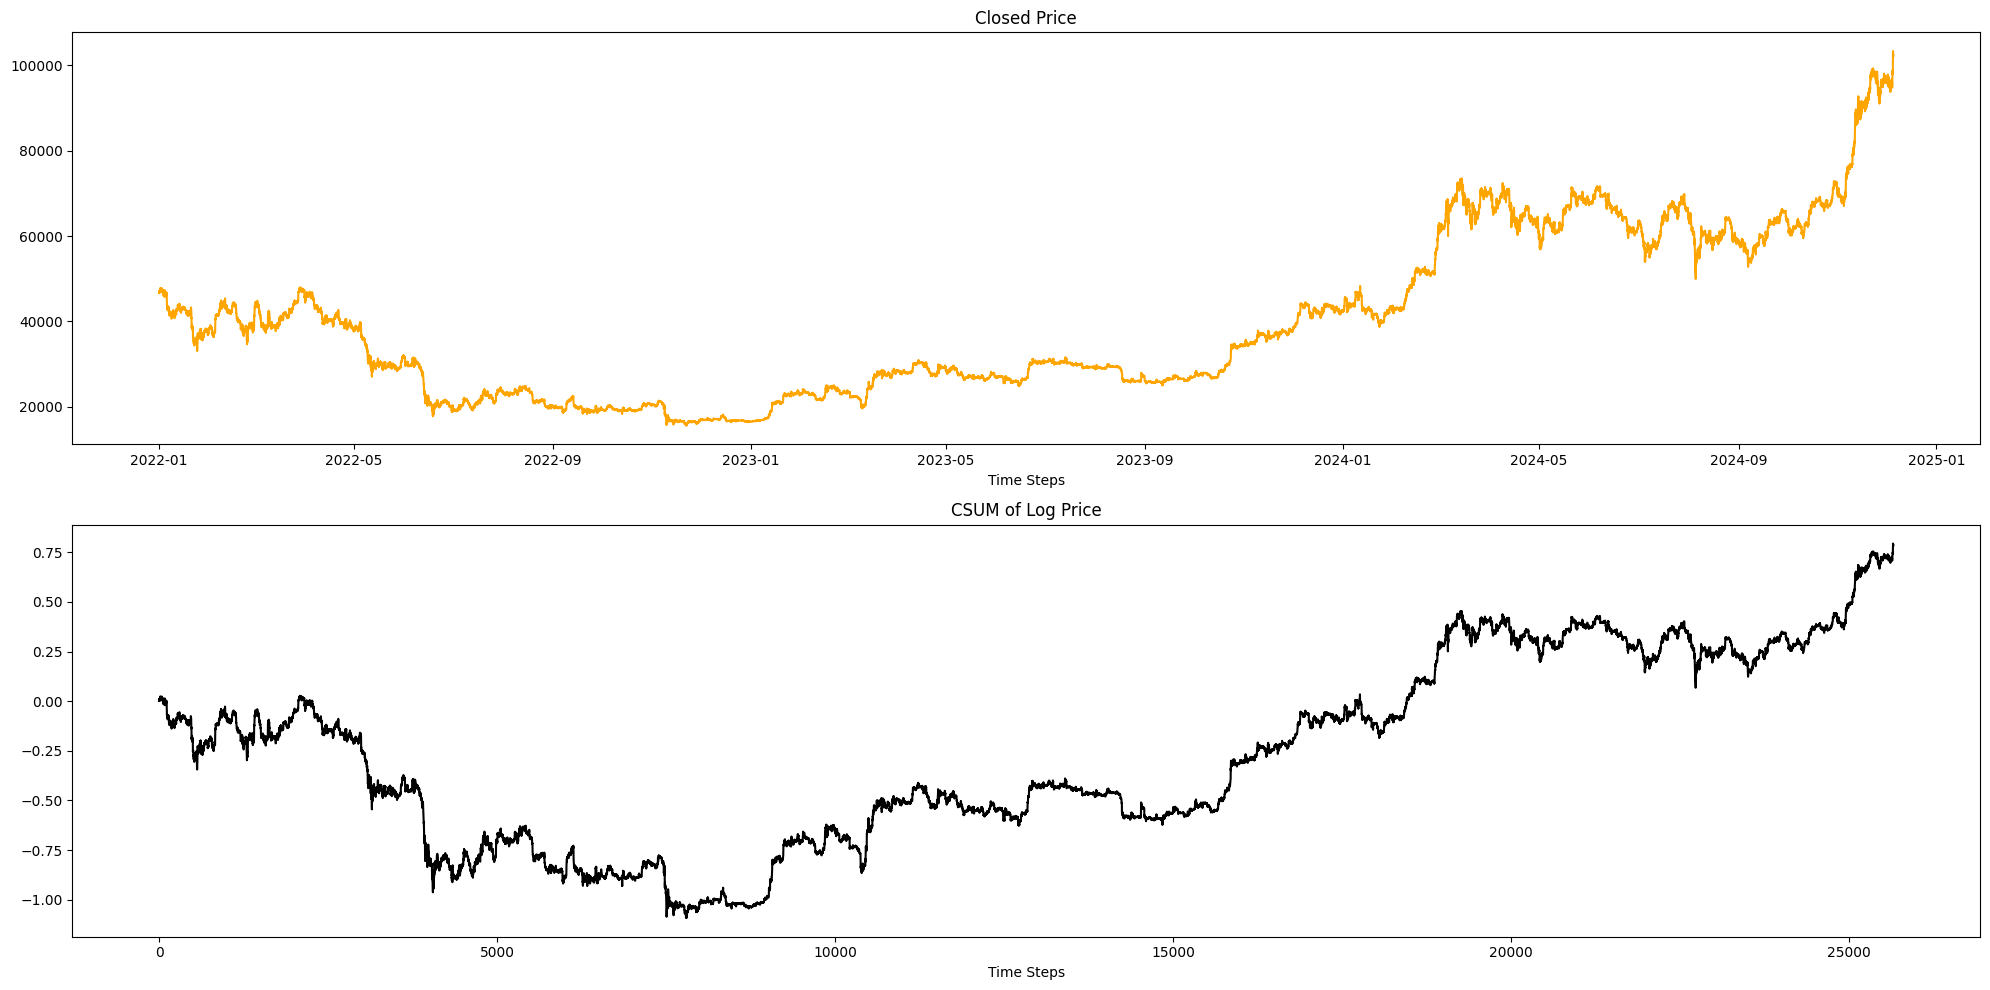

In [31]:
fig1, ax1 = plt.subplots(2, 1,figsize=(20,10))
ax1[0].plot(close, color='orange')
ax1[0].set_title('Closed Price')
ax1[0].set_xlabel('Time Steps')

ax1[1].plot(log_prices_csum, color='black')
ax1[1].set_title('CSUM of Log Price')
ax1[1].set_xlabel('Time Steps')

fig1.tight_layout()

In [32]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
input_window = 7 # number of input time steps
output_window = 1 # number of prediction steps (equals to one)
batch_size = 100

In [33]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout_p=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:x.size(0), :])

In [34]:
class Transformer(nn.Module):
    def __init__(self, feature_size=200, num_layers=2, dropout=0.1):
        # feautre_size equals to embedding dimension (d_model)
        super().__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)

        # Apply nhead multi-head attention
        # d_key, d_query, d_value = d_model // n_head
        self.encoder_layer = TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)

        # Use num_layers encoders
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # For simple time-series prediction, decoder just uses FC layer
        self.decoder = nn.Linear(feature_size, 1)
        self._init_weights()

    def _init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, size):
        mask = torch.tril(torch.ones(size, size) == 1) # Lower Triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask

In [35]:
def create_inout_sequences(input_data, input_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + output_window: i + input_window + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [36]:
def get_data(data_raw, split):
    split = round(split * len(data_raw))
    train_data = data_raw[:split]
    test_data = data_raw[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  # Training data scaling

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_sequence = create_inout_sequences(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)

In [37]:
train_data, test_data = get_data(log_prices, 0.7) # 70% for train and 30% for test

In [38]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    data_in = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return data_in, target

In [39]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss = total_loss + loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [40]:
def evaluate(model, data_source):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [41]:
def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return predicted_seq, real_seq

In [42]:
model = Transformer().to(device)

criterion = nn.MSELoss()
lr = 0.00005

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

N_EPOCHS = 150

c:\Users\Mirom\Desktop\ML\ml-finance\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [43]:
for epoch in range(1, N_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_data)

    if (epoch % N_EPOCHS == 0):  # Valid model after last training epoch
        val_loss = evaluate(model, test_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch,
                                                                                   (time.time() - epoch_start_time),
                                                                                   val_loss))
        print('-' * 80)

    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()

c:\Users\Mirom\Desktop\ML\ml-finance\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


| epoch   1 |    35/  179 batches | lr 0.0000500000 | 135.15 ms | loss 0.1434655
| epoch   1 |    70/  179 batches | lr 0.0000500000 | 136.69 ms | loss 0.0519517
| epoch   1 |   105/  179 batches | lr 0.0000500000 | 118.87 ms | loss 0.0858192
| epoch   1 |   140/  179 batches | lr 0.0000500000 | 133.56 ms | loss 0.0627818
| epoch   1 |   175/  179 batches | lr 0.0000500000 | 125.10 ms | loss 0.0190691
--------------------------------------------------------------------------------
| end of epoch   1 | time: 23.22s
--------------------------------------------------------------------------------
| epoch   2 |    35/  179 batches | lr 0.0000451250 | 130.10 ms | loss 0.0197300
| epoch   2 |    70/  179 batches | lr 0.0000451250 | 134.33 ms | loss 0.0936526
| epoch   2 |   105/  179 batches | lr 0.0000451250 | 119.04 ms | loss 0.0566800
| epoch   2 |   140/  179 batches | lr 0.0000451250 | 124.59 ms | loss 0.0764113
| epoch   2 |   175/  179 batches | lr 0.0000451250 | 134.18 ms | loss 0.03

In [44]:
predicted_seq, real_seq = predict(model, test_data)

13.971483707427979 sec


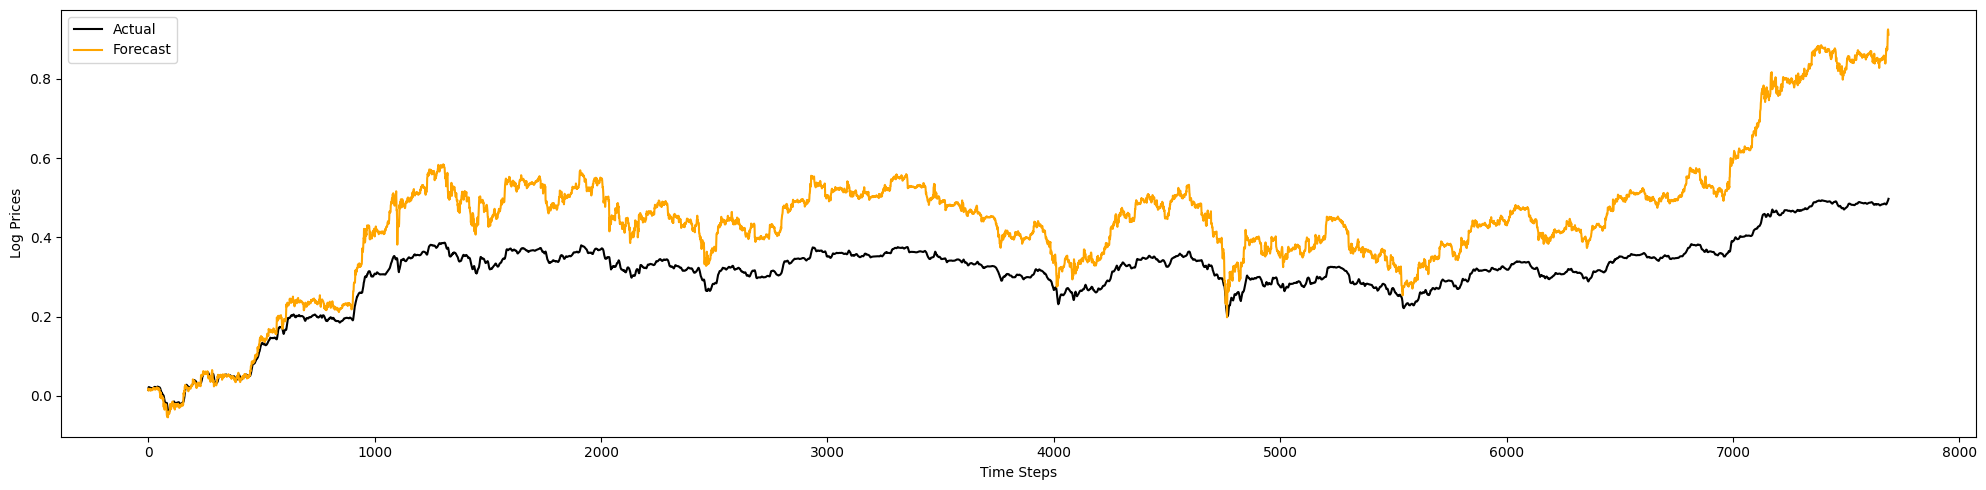

In [48]:
fig2, ax2 = plt.subplots(1, 1,figsize=(20,5))

ax2.plot(predicted_seq, color='black')
ax2.plot(real_seq, color='orange')
ax2.legend(['Actual', 'Forecast'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()

In [49]:
dfTest = pd.DataFrame(real_seq)
dfTest['closePricePred'] = predicted_seq.tolist()

#  возвращаем логарифм
y = np.log10(dfTest["closePricePred"])
dfTest["closePricePred"] = 10 ** y

dfTest = dfTest.set_axis(['closePrice','closePricePred'], axis=1)
dfTest['return_next'] = dfTest['closePrice'].pct_change()
dfTest['predict'] = dfTest['closePricePred'].pct_change()
dfTest['predict'] = np.where(dfTest['predict']>0,1,np.where(dfTest['predict']<0,-1,0))

dfTest['pnl'] = dfTest['return_next'] * dfTest['predict']
dfTest = dfTest.reset_index()
print('PNL: ',dfTest['pnl'].sum())

PNL:  13.557189643383026


c:\Users\Mirom\Desktop\ML\ml-finance\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Mirom\AppData\Local\Temp\ipykernel_16844\902354829.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  dfTest['predict'] = dfTest['closePricePred'].pct_change()


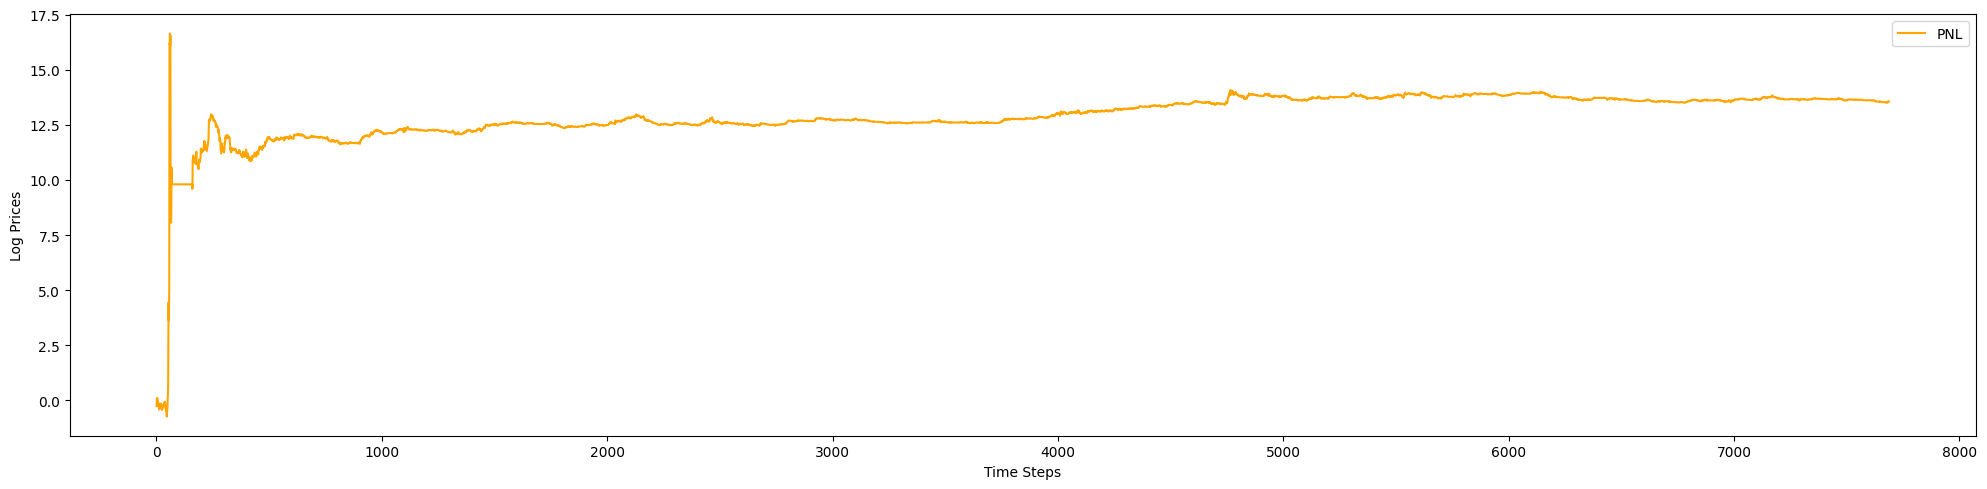

In [50]:
pnl = dfTest['pnl'].cumsum()
fig2, ax2 = plt.subplots(1, 1,figsize=(20,5))

ax2.plot(pnl, color='orange')
ax2.legend(['PNL'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()